In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
from tabulate import tabulate

In [2]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [3]:
# preprocessing steps for numerical and categorical data (replace output value, replace missing value, encode, scale)

# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

numeric_features = df.drop(["y"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

C:\Users\PC\AppData\Local\Temp\ipykernel_16744\2830836920.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [4]:
# undersampling
from sklearn.utils import resample

df_majority = df[df["y"] == 0]
df_minority = df[df["y"] == 1]

df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_undersampled = pd.concat([df_majority_undersampled, df_minority])

In [5]:
# split dataset
X = df_undersampled.drop(['y'], axis=1)
y = df_undersampled['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# storing performance result
performance_result = [
    ["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "F1 Score (Macro)", "Duration"]
]

# function for performance metrics
def print_performance(y_test, y_pred, model, et, st):
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Converted', 'Converted'],
                yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    performance_result.append([model, accuracy, precision, recall, f1, f1_macro, et - st])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"F1 Score (Macro): {f1_macro}")
    print(f"Duration (s): {et-st}")

In [7]:
# cross validation functions
def model_cross_validation(model, name, X_training):
    cv_scores = cross_validate(model, X_training, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    cv_results_df = pd.DataFrame({
        "Fold": [1, 2, 3, 4, 5],
        "Accuracy": cv_scores['test_accuracy'],
        "Precision": cv_scores['test_precision'],
        "Recall": cv_scores['test_recall'],
        "F1-Score": cv_scores['test_f1']
    })

    cv_results_df.loc["Mean"] = ["Mean Accuracy", cv_scores['test_accuracy'].mean(), cv_scores['test_precision'].mean(), cv_scores['test_recall'].mean(), cv_scores['test_f1'].mean()]
    cv_results_df.loc["Std Dev"] = ["Mean Standard Deviation", cv_scores['test_accuracy'].std(), cv_scores['test_precision'].std(), cv_scores['test_recall'].std(), cv_scores['test_f1'].std()]
    cv_results_df.to_csv(str(name) + "_cross_validation.csv", index=False)

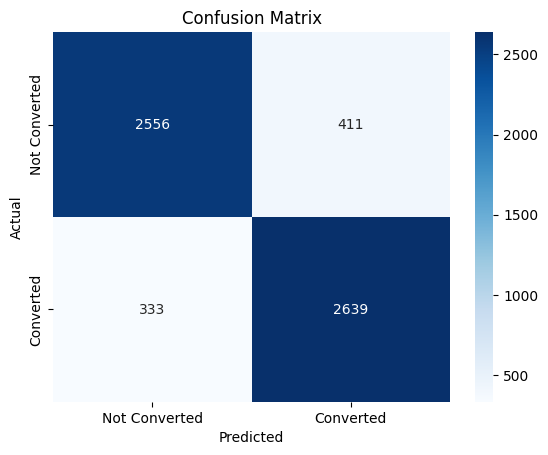

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2967
           1       0.87      0.89      0.88      2972

    accuracy                           0.87      5939
   macro avg       0.87      0.87      0.87      5939
weighted avg       0.87      0.87      0.87      5939

Accuracy: 0.874726384913285
Precision: 0.8652459016393442
Recall: 0.8879542395693136
F1 Score: 0.8764530056459648
F1 Score (Macro): 0.8747019126590481
Duration (s): 0.07732200622558594


In [8]:
# lr
st = time.time()
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter = 1000))])

lr_model.fit(X_train, y_train)
et = time.time()

y_pred = lr_model.predict(X_test)

print_performance(y_test, y_pred, "LR", et, st)
model_cross_validation(lr_model, "lr", X_train)

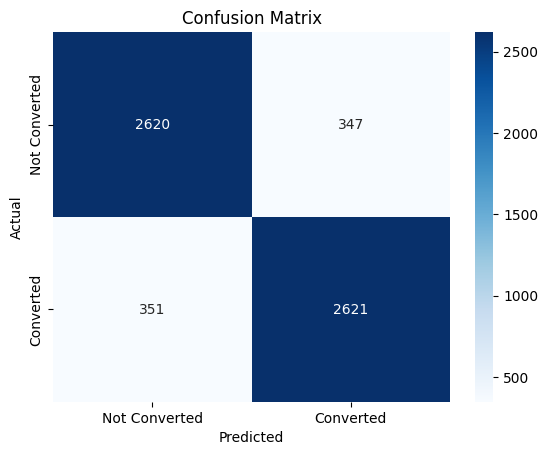

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2967
           1       0.88      0.88      0.88      2972

    accuracy                           0.88      5939
   macro avg       0.88      0.88      0.88      5939
weighted avg       0.88      0.88      0.88      5939

Accuracy: 0.882471796598754
Precision: 0.8830862533692723
Recall: 0.8818977119784657
F1 Score: 0.8824915824915824
F1 Score (Macro): 0.8824717932666737
Duration (s): 0.028035879135131836


In [9]:
# knn
st = time.time()
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)
et = time.time()

y_pred = knn_model.predict(X_test)

print_performance(y_test, y_pred, "KNN", et, st)
model_cross_validation(knn_model, "knn", X_train)

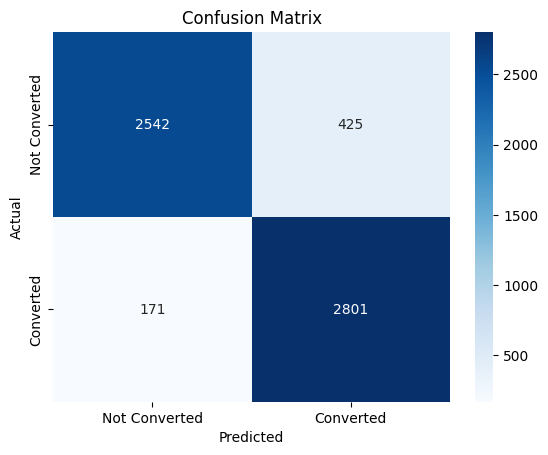

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2967
           1       0.87      0.94      0.90      2972

    accuracy                           0.90      5939
   macro avg       0.90      0.90      0.90      5939
weighted avg       0.90      0.90      0.90      5939

Accuracy: 0.8996464051187069
Precision: 0.8682579045257285
Recall: 0.9424629878869448
F1 Score: 0.9038399483704421
F1 Score (Macro): 0.8994551854528268
Duration (s): 1.4044175148010254


In [10]:
# svm
st = time.time()
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])

svm_model.fit(X_train, y_train)
et = time.time()

y_pred = svm_model.predict(X_test)

print_performance(y_test, y_pred, "SVM", et, st)
model_cross_validation(svm_model, "svm", X_train)

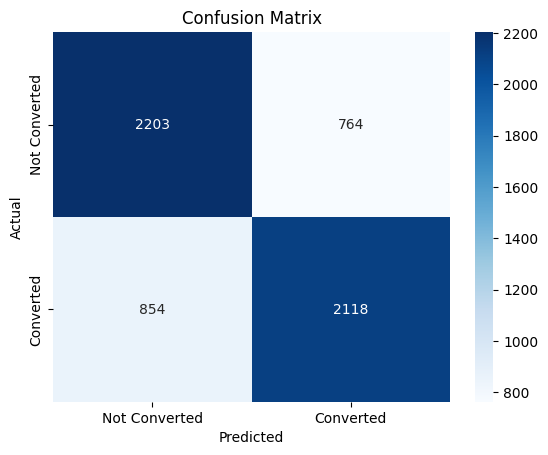

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      2967
           1       0.73      0.71      0.72      2972

    accuracy                           0.73      5939
   macro avg       0.73      0.73      0.73      5939
weighted avg       0.73      0.73      0.73      5939

Accuracy: 0.7275635628893753
Precision: 0.7349063150589868
Recall: 0.7126514131897712
F1 Score: 0.7236077895456099
F1 Score (Macro): 0.7275077460344251
Duration (s): 0.04001021385192871


In [11]:
# nb
st = time.time()
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BernoulliNB())])

nb_model.fit(X_train, y_train)
et = time.time()

y_pred = nb_model.predict(X_test)

print_performance(y_test, y_pred, "NB", et, st)
model_cross_validation(nb_model, "nb", X_train)

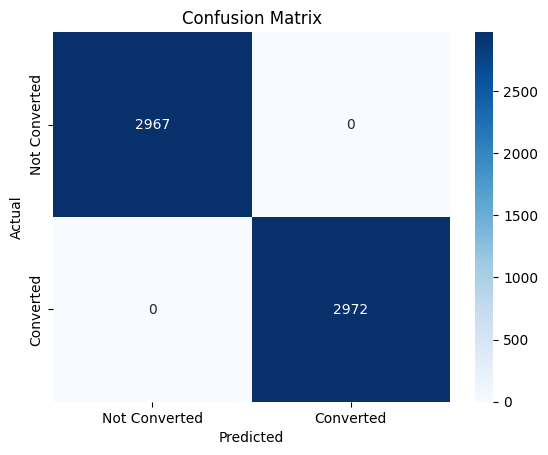

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2967
           1       1.00      1.00      1.00      2972

    accuracy                           1.00      5939
   macro avg       1.00      1.00      1.00      5939
weighted avg       1.00      1.00      1.00      5939

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
F1 Score (Macro): 1.0
Duration (s): 0.0642242431640625


In [12]:
# dt
st = time.time()
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])

dt_model.fit(X_train, y_train)
et = time.time()

y_pred = dt_model.predict(X_test)

print_performance(y_test, y_pred, "DT", et, st)
model_cross_validation(dt_model, "dt", X_train)

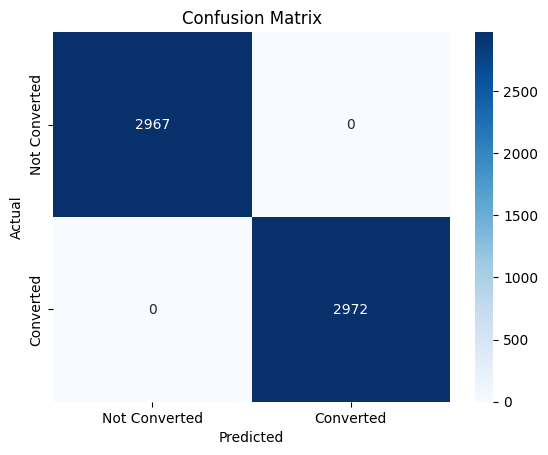

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2967
           1       1.00      1.00      1.00      2972

    accuracy                           1.00      5939
   macro avg       1.00      1.00      1.00      5939
weighted avg       1.00      1.00      1.00      5939

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
F1 Score (Macro): 1.0
Duration (s): 0.6845502853393555


In [13]:
# rf
st = time.time()
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, y_train)
et = time.time()

y_pred = rf_model.predict(X_test)

print_performance(y_test, y_pred, "RF", et, st)
model_cross_validation(rf_model, "rf", X_train)

C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


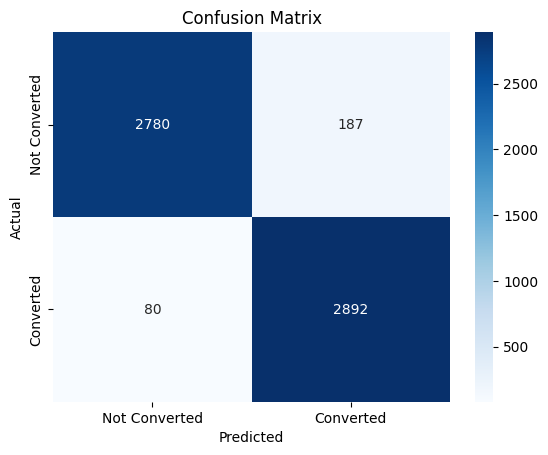

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2967
           1       0.94      0.97      0.96      2972

    accuracy                           0.96      5939
   macro avg       0.96      0.96      0.96      5939
weighted avg       0.96      0.96      0.96      5939

Accuracy: 0.9550429365212999
Precision: 0.9392659954530692
Recall: 0.9730820995962315
F1 Score: 0.9558750619732276
F1 Score (Macro): 0.95502694234752
Duration (s): 6.718641757965088


C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
# nn
st = time.time()
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier())])

nn_model.fit(X_train, y_train)
et = time.time()

y_pred = nn_model.predict(X_test)

print_performance(y_test, y_pred, "NN", et, st)
model_cross_validation(nn_model, "nn", X_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_16744\2629766587.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)


186/186 [==============================] - 0s 950us/step


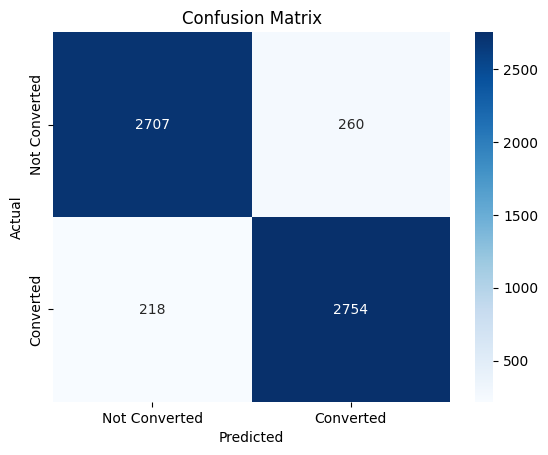

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2967
           1       0.91      0.93      0.92      2972

    accuracy                           0.92      5939
   macro avg       0.92      0.92      0.92      5939
weighted avg       0.92      0.92      0.92      5939

Accuracy: 0.9195150698770836
Precision: 0.913735899137359
Recall: 0.9266487213997309
F1 Score: 0.920147009689275
F1 Score (Macro): 0.9195100289451127
Duration (s): 123.73619818687439
47/47 [==============================] - 0s 967us/step


In [15]:
# honn
def higher_order_nn(input_dim, order):
    inputs = Input(shape=(input_dim,))
    x = inputs

    for i in range(order):
        x = Dense(64, activation="relu")(x) # input layer

    outputs = Dense(1, activation="sigmoid")(x) # output layer

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_honn_model():
    input_dim = X_train_preprocessed.shape[1]
    order = 2
    model = higher_order_nn(input_dim, order)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

st = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train)
honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)
honn_model.fit(X_train_preprocessed, y_train)
et = time.time()

X_test_preprocessed = preprocessor.transform(X_test)
y_pred = honn_model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)

print_performance(y_test, y_pred, "HONN", et, st)
model_cross_validation(honn_model, "honn", X_train_preprocessed)

In [16]:
# performance comparison table
print(tabulate(performance_result, headers = "firstrow", tablefmt = "outline"))

# save to csv file
df_performance = pd.DataFrame(performance_result[1:], columns = performance_result[0])
df_performance.to_csv('performance_overview.csv', index = False)

+-------------+------------+-------------+----------+------------+--------------------+-------------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 Score |   F1 Score (Macro) |    Duration |
+=============+============+=============+==========+============+====================+=============+
| LR          |   0.874726 |    0.865246 | 0.887954 |   0.876453 |           0.874702 |   0.077322  |
| KNN         |   0.882472 |    0.883086 | 0.881898 |   0.882492 |           0.882472 |   0.0280359 |
| SVM         |   0.899646 |    0.868258 | 0.942463 |   0.90384  |           0.899455 |   1.40442   |
| NB          |   0.727564 |    0.734906 | 0.712651 |   0.723608 |           0.727508 |   0.0400102 |
| DT          |   1        |    1        | 1        |   1        |           1        |   0.0642242 |
| RF          |   1        |    1        | 1        |   1        |           1        |   0.68455   |
| NN          |   0.955043 |    0.939266 | 0.973082 |   0.955875 |           0.955